# Generate Order Lists
* Order History - Order details of the previous 6 months given as input.
* Order List - Orders in real time.

The Order History is past data and is known. The Order List may be predicted but is not known.

Order lists are generated from order history, keeping in mind that the more frequently ordered items in order history are more likely to be present in the current order list

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import json
import glob

## Import the dataset

In [3]:
DATA_PATH = "../data/"
ORDER_HISTORY_PATH = os.path.join(DATA_PATH, "order_history_small.csv")

In [4]:
df_oh = pd.read_csv(ORDER_HISTORY_PATH)
df_oh.head()

,id,name,quantity,volume,cover
0,1,Organic Valley Eggs,5650,600,7
1,2,ChefMaster Stainless Steel Mixing Bowls,5120,2000,5
2,3,Kirkland Signature Organic Milk,4880,1000,10
3,4,Tide Liquid Laundry Detergent,2820,1500,14
4,5,General Mills Honey Nut Cheerios,1250,450,20


## Exploratory Data Analysis

In [5]:
# Sort the DataFrame by 'quantity' in descending order and get the top few
N = 12
top_items = df_oh.sort_values(by='quantity', ascending=False).head(N)

# Extract item names and their quantities
item_names = top_items['name']
quantities = top_items['quantity']

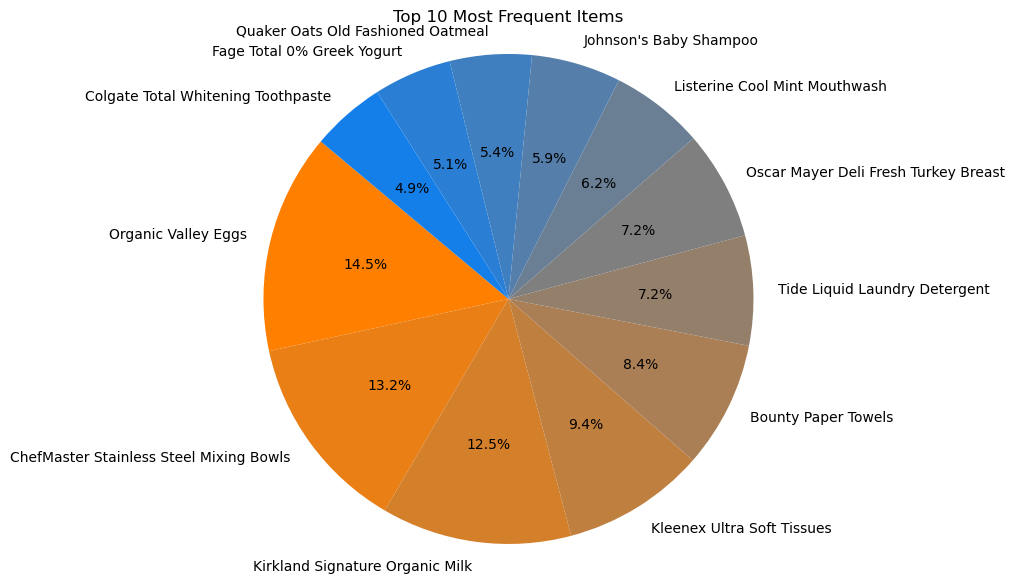

In [6]:
def generate_color_gradient(base_color, num_colors):
    """Generate a list of colors forming a gradient."""
    colors = []
    for i in range(num_colors):
        color = tuple(np.linspace(0, 1, 3) * i / num_colors + np.array(base_color) * (1 - i / num_colors))
        colors.append('#%02x%02x%02x' % tuple(int(c*255) for c in color))
    return colors


# Plot pie chart for each color gradient
colors = generate_color_gradient((1, 0.5, 0), len(item_names))

plt.figure(figsize=(10, 7))
plt.pie(quantities, labels=item_names, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title(f"Top 10 Most Frequent Items")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


## Generate Order List

In [7]:
# Calculate the total quantity of all items
total_quantity = df_oh['quantity'].sum()

# Calculate probability for each item
df_oh['probability'] = df_oh['quantity'] / total_quantity

In [8]:
total_prob = df_oh['probability'].sum()
print(total_prob)
df_oh.head(20)

1.0


,id,name,quantity,volume,cover,probability
0,1,Organic Valley Eggs,5650,600,7,0.121636
1,2,ChefMaster Stainless Steel Mixing Bowls,5120,2000,5,0.110226
2,3,Kirkland Signature Organic Milk,4880,1000,10,0.105059
3,4,Tide Liquid Laundry Detergent,2820,1500,14,0.060710
4,5,General Mills Honey Nut Cheerios,1250,450,20,0.026911
5,6,Bounty Paper Towels,3260,700,30,0.070183
6,7,Kleenex Ultra Soft Tissues,3670,400,30,0.079010
7,8,Dawn Ultra Dishwashing Liquid,1600,800,10,0.034446
8,9,Colgate Total Whitening Toothpaste,1900,300,5,0.040904
9,10,Listerine Cool Mint Mouthwash,2400,1200,10,0.051668


In [9]:
# Define the number of items to randomly pick
ORDER_LIST_LENGTH = 20

df_ol = df_oh.sample(n=ORDER_LIST_LENGTH, weights='probability', replace=True)

In [10]:
# Define the distribution for daily quantities
quantities = [1, 2, 3, 4, 5]
item_probabilities = [0.35, 0.25, 0.20, 0.12, 0.08]

# Assign random quantities based on the given distribution
df_ol['quantity'] = np.random.choice(quantities, size=ORDER_LIST_LENGTH, p=item_probabilities)

df_ol.head()

,id,name,quantity,volume,cover,probability
6,7,Kleenex Ultra Soft Tissues,5,400,30,0.079010
13,14,Planters Deluxe Whole Cashews,4,650,10,0.034446
3,4,Tide Liquid Laundry Detergent,1,1500,14,0.060710
0,1,Organic Valley Eggs,4,600,7,0.121636
2,3,Kirkland Signature Organic Milk,1,1000,10,0.105059


In [11]:
if 'probability' in df_ol.columns:
    df_ol = df_ol.drop(columns=['probability'])

output_path = "../data/order_list_small.csv"
df_ol.to_csv(output_path, index=False)  # index=False excludes row indices in the CSV file

print(f"DataFrame successfully written to {output_path}")


DataFrame successfully written to ../data/order_list_small.csv


## Batch the items into orders

In [12]:
# Read the CSV data from the file
file_path = '../data/order_history_small.csv'
items = []

with open(file_path, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        items.append({
            "id": int(row["id"]),
            "name": row["name"],
            "quantity": int(row["quantity"]),
            "volume": int(row["volume"]),
            "cover": int(row["cover"])
        })

### See how an item object looks

In [13]:
for i in range(3):
    print(items[i])

{'id': 1, 'name': 'Organic Valley Eggs', 'quantity': 5650, 'volume': 600, 'cover': 7}
{'id': 2, 'name': 'ChefMaster Stainless Steel Mixing Bowls', 'quantity': 5120, 'volume': 2000, 'cover': 5}
{'id': 3, 'name': 'Kirkland Signature Organic Milk', 'quantity': 4880, 'volume': 1000, 'cover': 10}


## Probability of an item being ordered

In [14]:
total_quantity_6m = sum([item['quantity'] for item in items])
total_quantity_6m

46450

In [15]:
item_probabilities = [item['quantity'] / total_quantity_6m for item in items]
print("Sum of item_probabilities = ", sum(item_probabilities))
print()

max_index = item_probabilities.index(max(item_probabilities))
min_index = item_probabilities.index(min(item_probabilities))

print("Most frequent item: ", items[max_index]['name'])
print("Probability: ", item_probabilities[max_index])
print()

print("Least frequent item: ", items[min_index]['name'])
print("Probability: ", item_probabilities[min_index])


Sum of item_probabilities =  1.0

Most frequent item:  Organic Valley Eggs
Probability:  0.1216361679224973

Least frequent item:  General Mills Honey Nut Cheerios
Probability:  0.02691065662002153


In [16]:
# Combine items and their probabilities
items_with_probabilities = list(zip(items, item_probabilities))

# Sort items by probability in descending order
sorted_items = sorted(items_with_probabilities, key=lambda x: x[1], reverse=True)

for item in sorted_items:
    print(f"{item[0]['name'][:20]} \t {(item[1]):.2%}")

Organic Valley Eggs 	 12.16%
ChefMaster Stainless 	 11.02%
Kirkland Signature O 	 10.51%
Kleenex Ultra Soft T 	 7.90%
Bounty Paper Towels 	 7.02%
Tide Liquid Laundry  	 6.07%
Oscar Mayer Deli Fre 	 6.03%
Listerine Cool Mint  	 5.17%
Johnson's Baby Shamp 	 4.95%
Quaker Oats Old Fash 	 4.52%
Fage Total 0% Greek  	 4.31%
Colgate Total Whiten 	 4.09%
Nature Valley Crunch 	 3.66%
Dawn Ultra Dishwashi 	 3.44%
Planters Deluxe Whol 	 3.44%
Sabra Classic Hummus 	 3.01%
General Mills Honey  	 2.69%


In [17]:
import random

# Generate orders
def generate_orders(num_orders, items, item_probabilities):
    orders = []
    for _ in range(num_orders):
        num_items_in_order = random.randint(1, 5)  # Each order can have between 1 and 5 items
        order_items = random.choices(items, weights=item_probabilities, k=num_items_in_order)
        orders.append({"items": order_items})
    return orders

In [18]:
from collections import Counter

# Calculate item frequencies
def calculate_item_frequencies(orders):
    item_counter = Counter()
    total_item_count = 0

    # Count occurrences of each item
    for order in orders:
        for item in order["items"]:
            item_counter[item["name"]] += 1
            total_item_count += 1

    # Calculate frequencies
    item_frequencies = {item: count / total_item_count for item, count in item_counter.items()}

    # Sort by frequency in descending order
    sorted_item_frequencies = sorted(item_frequencies.items(), key=lambda x: x[1], reverse=True)

    return sorted_item_frequencies

In [19]:
def gen_order_list(num_orders, file_num):
    # Generate a list of orders
    orders = generate_orders(num_orders, items, item_probabilities)

    # Save the orders to a JSON file
    with open(f'../data/orders/orders{file_num}.json', 'w') as json_file:
        json.dump(orders, json_file, indent=4)

    print("JSON file 'orders.json' created successfully.")

In [20]:
def gen_order_lists(num_orders, N):
    for file_num in range(N):
        gen_order_list(num_orders, file_num)
    
    print(f"{N} order list files have been created")

In [27]:
gen_order_lists(100, 2)

JSON file 'orders.json' created successfully.
JSON file 'orders.json' created successfully.
2 order list files have been created


### Clear all order lists

In [22]:
def clear_directory(directory_path):
    # Ensure the directory exists
    if not os.path.isdir(directory_path):
        print(f"Directory {directory_path} does not exist.")
        return

    # Use glob to match all files in the directory
    files = glob.glob(os.path.join(directory_path, '*'))
    
    # Loop through and delete each file
    for file in files:
        try:
            os.remove(file)
            print(f"Deleted {file}")
        except Exception as e:
            print(f"Error deleting file {file}: {e}")

# Example usage
clear_directory('../data/orders/')

Deleted ../data/orders\orders0.json
Deleted ../data/orders\orders1.json
Deleted ../data/orders\orders2.json
